In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from datasets.SP100Stocks import SP100Stocks
from notebooks.models import TGCN

# Optimal stock portfolio selection
This notebook illustrates the use of the previously trained classifier for optimal stock portfolio selection. Similarly to [G. Pacreau et al., Graph Neural Networks for Asset Management](https://ssrn.com/abstract=3976168), a softmax is applied to the output of the network to get the probability of the stock going up, and the top $n$ stocks are selected to form the portfolio. It is evaluated compared to the market return, which is the average return of all the stocks in the dataset.

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [66]:
weeks_ahead = 1

dataset = SP100Stocks(future_window=weeks_ahead * 5)
dataset, dataset[0]

(SP100Stocks(1187),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 5], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 5]))

In [74]:
train_part = .9

test_data = dataset[int(len(dataset) * train_part):]  # each day
test_data = [test_data[idx] for idx in range(0, len(test_data), 5)]  # each week
test_data[0].return_since_previous = torch.zeros(test_data[0].x.size(0))
for idx in range(1, len(test_data)):
	test_data[idx].return_since_previous = (test_data[idx].close_price[:, -1] / test_data[0].close_price[:, -1] - 1)
print(f"Test data: {len(test_data)} weeks")

Test data: 24 weeks


## Loading the model
The previously trained model is loaded.

In [75]:
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2

model = TGCN(in_channels, out_channels, hidden_size, layers_nb)
model.load_state_dict(torch.load("models/saved_models/UpDownTrend_TGCN.pt"))
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0): GATv2Conv(8, 16, heads=1)
          (1): GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=40, out_features=16, bias=True)
      (lin_r): Linear(in_features=40, out_features=16, bias=True)
      (lin_c): Linear(in_features=40, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0-1): 2 x GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

## Portfolio selection

In [76]:
def get_topk(model_out: torch.tensor, k: int, largest: bool = True) -> torch.tensor:
		return torch.topk(model_out, k, largest=largest).indices

In [79]:
topks = [5, 10, 20]

portfolio_returns = [[1.] for _ in range(len(topks))]
market_returns = [1.]

model_out = model(test_data[0].x, test_data[0].edge_index, test_data[0].edge_weight).squeeze(1)
last_close = test_data[0].close_price[:, -1]

for idx in range(1, len(test_data)):
	returns = test_data[idx].close_price[:, -1] / last_close
	for j, k in enumerate(topks):
		topk_stocks = get_topk(model_out, k, largest=False)
		portfolio_returns[j].append(returns[topk_stocks].mean().item() * portfolio_returns[j][-1])
	market_returns.append(returns.mean().item() * market_returns[-1])
	last_close = test_data[idx].close_price[:, -1]
	model_out = model(test_data[idx].x, test_data[idx].edge_index, test_data[idx].edge_weight).squeeze(1)

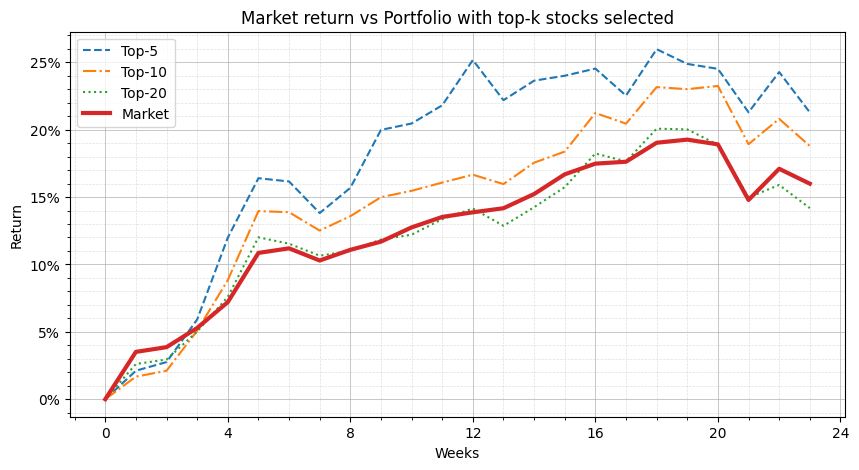

In [80]:
plt.figure(figsize=(10, 5))

for j, k in enumerate(topks):
	plt.plot(portfolio_returns[j], label=f"Top-{k}", linestyle=['--', '-.', ':'][j])
plt.plot(market_returns, label="Market", linewidth=3)
plt.grid(which='major', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5, alpha=.4)
plt.title(f"Market return vs Portfolio with top-k stocks selected")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{(x - 1) * 100:.0f}%"))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Return")
plt.show()

We see that the $\text{top--}k$ portfolios outperform the market by up to $80\%$ ($25\% \text{ vs } 14\%$).